In [1]:
from utils import sars2_genome_info, add_syn_mut_attribute, add_mut_accumulation_attr, add_mut_at_node_attr
from utils_plotting import get_color_palette, convert_linege_names
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import json
import datetime
from scipy import stats

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


## Determine if there is a correlation between vaccination rate and S1 mutation accumulation

Read in table of vaccination rate per country by date. Vaccination data comes from:

Mathieu, E., Ritchie, H., Ortiz-Ospina, E. et al. A global database of COVID-19 vaccinations. Nat Hum Behav (2021). https://doi.org/10.1038/s41562-021-01122-8

In [5]:
vaccination_rates = pd.read_csv('vaccination_rates_country.csv', skiprows=1)

Convert dates into decimal dates

In [7]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [33]:
toYearFraction(datetime.datetime.strptime('2021-09-10', '%Y-%m-%d'))

2021.690296803653

Create a column in the vaccination dataframe to store date as decimal year

In [9]:
vaccination_rates['date'] = pd.to_datetime(vaccination_rates['date'])
vaccination_rates['num_date'] = vaccination_rates['date'].apply(toYearFraction)

Read in the SARS-CoV-2 phylogeny

In [21]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-08-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [22]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

In [23]:
tree = add_syn_mut_attribute(tree)

In [24]:
tree = add_mut_accumulation_attr(tree)

In [25]:
tree = add_mut_at_node_attr(tree)

For every internal branch, find date, country and number of S1 mutations (both total accumulated and number that arose on this branch)

In [26]:
def get_s1_vacc_on_internals(min_date):

    internal_branches = []

    for node in tree.find_clades(terminal=False):

        # use internal branches with at least 3 descending tips, to minimize tip effects
        if len(node.get_terminals())>=3:
            if hasattr(node, 'branch_attrs'):
                date = node.node_attrs['num_date']['value']

                # only look at dates where countries had really started vaccinating (default is May 1)
                if date >= min_date:
                    country = node.node_attrs['country']['value']

                    # change name to match vaccination data
                    if country == 'USA':
                        country = 'United States'
                    elif country in ['Democratic Republic of the Congo', 'Republic of the Congo']:
                        country = 'Congo'

                    # filter vaccination data to only the inferred country of this branch
                    vacc_country= vaccination_rates[vaccination_rates['location']==country]

                    # find percentage of country vaccinated at the branch's date
                    # use vaccination data from the closest date to the inferred branch date 
                    # (only if closest date with vacc data is within 10 days)
                    vacc_country_date = vacc_country[(vacc_country['num_date']>=(date-0.0274)
                                                     )& (vacc_country['num_date']<=(date+0.0274))]
                    
                    # numbers for individuals with only one dose
                    # order information by closest to the branch date
                    vacc_at_closest_dates = list(vacc_country.iloc[(vacc_country['num_date']-date).abs().argsort()
                                                                  ]['people_fully_vaccinated_per_hundred'])
                    # get rid of null values
                    vacc_at_closest_dates_drop_na = [x for x in vacc_at_closest_dates if not pd.isna(x)]
                    
                    # if there are any non-null values in the date range
                    if len(vacc_at_closest_dates_drop_na)!= 0:
                        num_fully_vaccinated = vacc_at_closest_dates_drop_na[0]


                        internal_branches.append({'date': date,
                                                 'country': country,
                                                 'percent_fully_vaccinated': num_fully_vaccinated,
                                                 's1_accumulated': node.node_attrs['s1_accumulation'],
                                                 's1_syn_accumulated': node.node_attrs['s1_syn_accumulation'],
                                                 's1_at_node':node.nonsyn_at_node['S1'], 
                                                 's1_syn_at_node':node.syn_at_node['S1']})


    s1_vaccination_df = pd.DataFrame(internal_branches)
    
    return s1_vaccination_df


In [52]:
def plot_s1_vacc_correlation(min_date = 2021.33, filename=None):
    
    s1_vaccination_df = get_s1_vacc_on_internals(min_date)

    
    fig, axes = plt.subplots(2,1 , figsize=(5,7), sharex=True)
    plt.tight_layout()
    
    subplot_categories = [('S1', 'Nonsynonymous', "#4770eb", 's1_accumulated'), 
                          ('S1', 'Synonymous', "#5094e3", 's1_syn_accumulated')]
    
    for i, ax in enumerate(axes.flat):
        ax = sns.scatterplot(x='percent_fully_vaccinated', y=subplot_categories[i][3], data=s1_vaccination_df, 
                        color=subplot_categories[i][2], s=80, ax=ax)
        sns.regplot(x='percent_fully_vaccinated', y=subplot_categories[i][3], scatter=False, ax=ax, 
                    data=s1_vaccination_df, line_kws={"color":'black'}, ci=95)
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(s1_vaccination_df['percent_fully_vaccinated'], 
                                                               s1_vaccination_df[subplot_categories[i][3]])
        ax.annotate(f'$r$: {round(r_value,3)}', xycoords = 'axes fraction',
                xy=(0.8, 0.9), size=14, va='top', ha='left')
        
        ax.set_ylabel(f'S1 {subplot_categories[i][1]} Mutations', fontsize = 14)
        ax.set_xlabel('Percent Fully Vaccinated', fontsize = 14)
        
        if i==1:
            ax.set_yticks([0,1,2])
    
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(hspace=0.2)


    plt.setp(ax.get_yticklabels(), fontsize=12)
    plt.setp(ax.get_xticklabels(), fontsize=12)

    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    

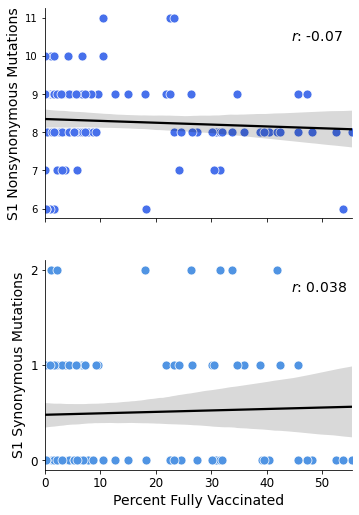

In [53]:
plot_s1_vacc_correlation(filename='plots/s1_vaccrate_20210910.png')